In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from skmap.misc import find_files, GoogleSheet, ttprint
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from trees_rf import TreesRandomForestRegressor
from model_fit import read_features, cfi_calc, parameter_fine_tuning, calc_ccc, separate_data, rscfi, textures_bw_transform
from model_fit import accuracy_plot, plot_top_features, pdp_hexbin, plot_histogram, calc_metrics, accuracy_strata_plot
import warnings
from sklearn.inspection import permutation_importance
warnings.filterwarnings('ignore')
import os
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import json
from datetime import datetime

folder_path = '/mnt/ripley/global_soc/scikit-map/global-soil-mapping'
# version = "20250204"
version = "20250523"

prop_list = ['texture1', 'texture2']
transforms_dict = {
    'texture1': None,
    'texture2': None,
}

min_convs_num = 60
max_convs_num = 120

# Model evaluation
### generate predictions for evaluation

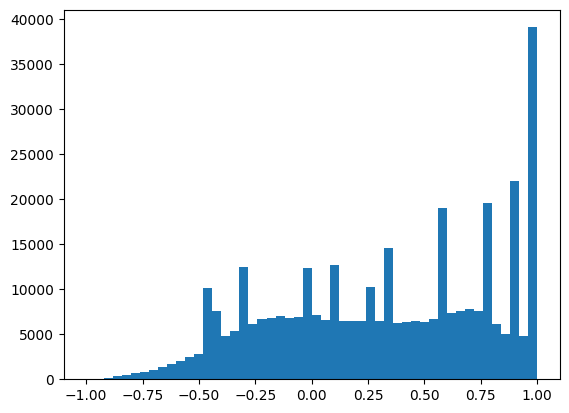

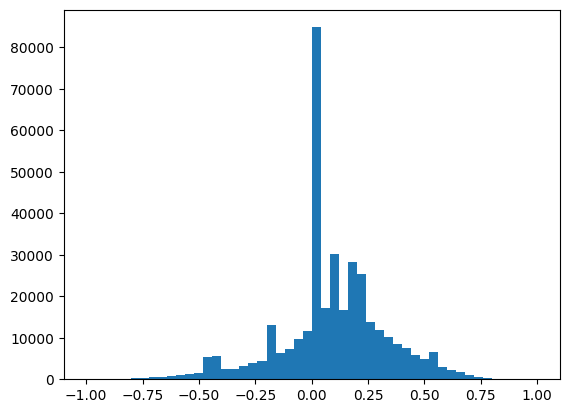

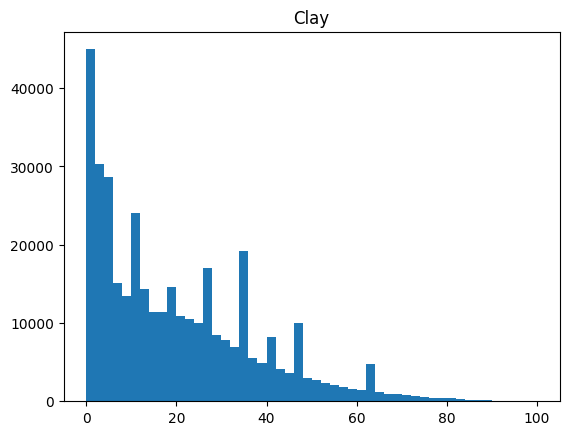

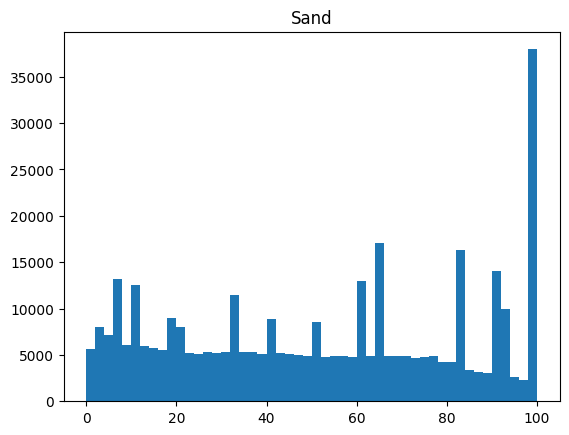

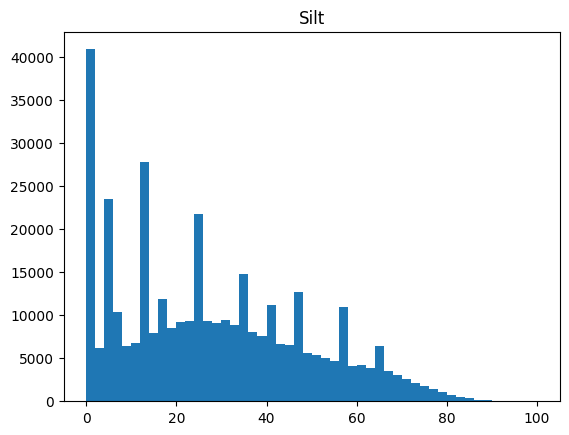

In [12]:
output_folder = f'{folder_path}/textures'



train = pd.read_parquet(f'{output_folder}/data_train_textures_v{version}.pq')
test = pd.read_parquet(f'{output_folder}/data_test_textures_v{version}.pq')
cal = pd.read_parquet(f'{output_folder}/data_cal_textures_v{version}.pq')

df = pd.concat([cal, test, train], axis=0)

plt.hist(df['texture1'], 50)
plt.show()

plt.hist(df['texture2'], 50)
plt.show()


plt.hist(df['clay'], 50)
plt.title('Clay')
plt.show()
plt.hist(df['sand'], 50)
plt.title('Sand')
plt.show()
plt.hist(df['silt'], 50)
plt.title('Silt')
plt.show()

In [2]:
from sklearn.model_selection import LeaveOneGroupOut

output_folder = f'{folder_path}/textures'

for prop in prop_list:
    print(f'\n{prop}--------------------------------------------------------------')
    space = transforms_dict[prop]
    os.makedirs(output_folder, exist_ok=True)
    
    train = pd.read_parquet(f'{output_folder}/data_train_textures_v{version}.pq')
    test = pd.read_parquet(f'{output_folder}/data_test_textures_v{version}.pq')
    tgt = prop
    
    covs = read_features(f'{output_folder}/feature_selected_{prop}_v{version}.txt') # read in
    test[covs] = test[covs].fillna(test[covs].median())
    train[covs] = train[covs].fillna(train[covs].median())
    
    # feature importance
    fi_df = pd.DataFrame(covs, columns=['feature'])
    
    # models
    model_list = find_files(output_folder,f'*model*rf*{prop}*{version}*joblib')
    model_list = [str(i) for i in model_list]
    keep_col_cv = ['olc_id', 'site_key', 'source_db','year', 'hzn_dep', 'hzn_dep_bin', 'lat', 'lon', 
                'clm_class', 'clm_code', prop, tgt]
    keep_col_test = ['olc_id', 'site_key', 'source_db','year', 'hzn_dep', 'hzn_dep_bin', 'lat', 'lon', 
                'clm_class', 'clm_code', prop, tgt]
    for iii in range(len(model_list)):
        model = joblib.load(model_list[iii])
        model.n_jobs =90
        model_name = model_list[iii].split('_')[-2].split('.')[0]
    
        # cross validation------------------------------------------------------------
        # spatial cv
        cv = GroupKFold(n_splits=5) 
        ttprint(f'start spatial CV for {model_name}')
        y_scv = cross_val_predict(model, train[covs], train[tgt], cv=cv, groups=train['tile_id'])
        ttprint(f'finish spatial CV for {model_name}')
        train[f'{tgt}_cv.spatial_{model_name}'] = y_scv

        # temporal cv
        tgroups = train['year']
        logo = LeaveOneGroupOut()
        ttprint(f'start temporal CV for {model_name}')
        y_tcv = cross_val_predict(model, train[covs], train[tgt], cv=logo.split(train[covs], train[tgt], tgroups))
        ttprint(f'finish temporal CV for {model_name}')
        train[f'{tgt}_cv.loyo_{model_name}'] = y_tcv

        # test---------------------------------------------------------------------------
        ttprint(f'start test prediction for {model_name}')
        model.fit(train[covs], train[tgt])
        y_val = model.predict(test[covs])
        ttprint(f'finish test prediction for {model_name}')
        test[f'{tgt}_test_{model_name}'] = y_val
        
        # variable importance
        pfi = permutation_importance(model, test[covs], test[tgt], n_jobs=80, n_repeats=10, random_state=42)
        fi_df[f'{model_name} permutation importance'] = pfi.importances_mean
        
        print([f'{tgt}_cv.loyo_{model_name}', f'{tgt}_cv.spatial_{model_name}'])
        keep_col_cv = keep_col_cv + [f'{tgt}_cv.loyo_{model_name}', f'{tgt}_cv.spatial_{model_name}']
        keep_col_test = keep_col_test + [f'{tgt}_test_{model_name}']
        
    # save
    # date_str = datetime.today().strftime('%Y%m%d')
    fi_df.to_csv(f'{output_folder}/feature_importance_{prop}_v{version}.csv',index=False)
    train[keep_col_cv].to_csv(f'{output_folder}/prediction_cv_{prop}_v{version}.csv',index=False)
    test[keep_col_test].to_csv(f'{output_folder}/prediction_test_{prop}_v{version}.csv',index=False)


texture1--------------------------------------------------------------
[12:02:36] start spatial CV for ccc
[12:03:30] finish spatial CV for ccc
[12:03:30] start temporal CV for ccc
[12:08:34] finish temporal CV for ccc
[12:08:34] start test prediction for ccc
[12:08:48] finish test prediction for ccc
['texture1_cv.loyo_ccc', 'texture1_cv.spatial_ccc']

texture2--------------------------------------------------------------
[12:09:32] start spatial CV for ccc
[12:10:18] finish spatial CV for ccc
[12:10:18] start temporal CV for ccc
[12:14:34] finish temporal CV for ccc
[12:14:34] start test prediction for ccc
[12:14:46] finish test prediction for ccc
['texture2_cv.loyo_ccc', 'texture2_cv.spatial_ccc']


### calculate metrics and plot accuracy figure


texture1--------------------------------------------------------------

texture2--------------------------------------------------------------


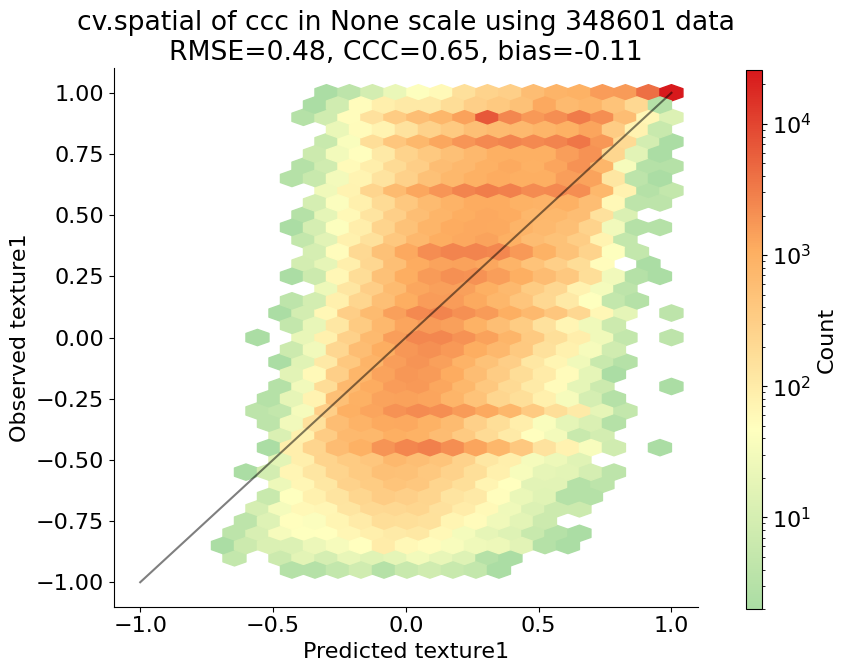

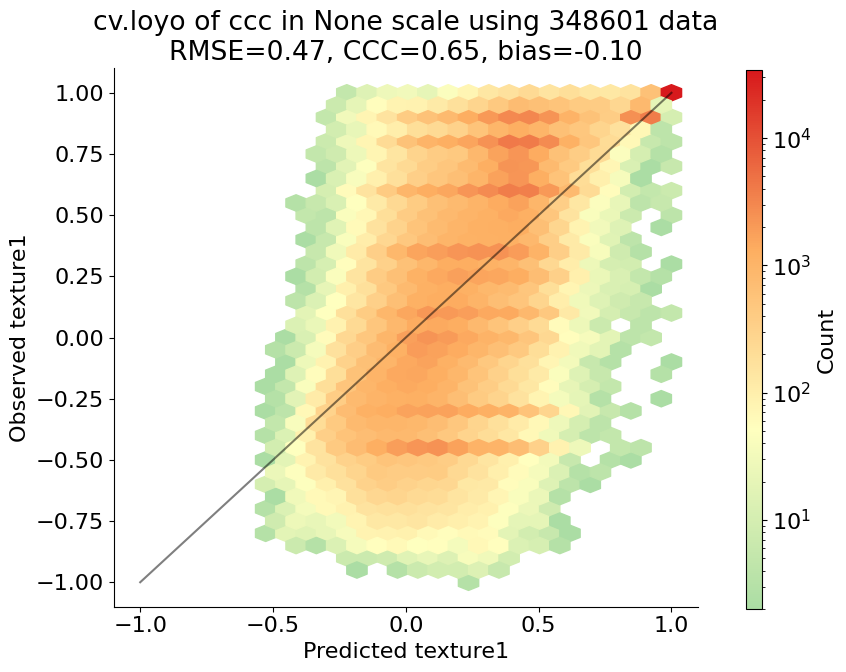

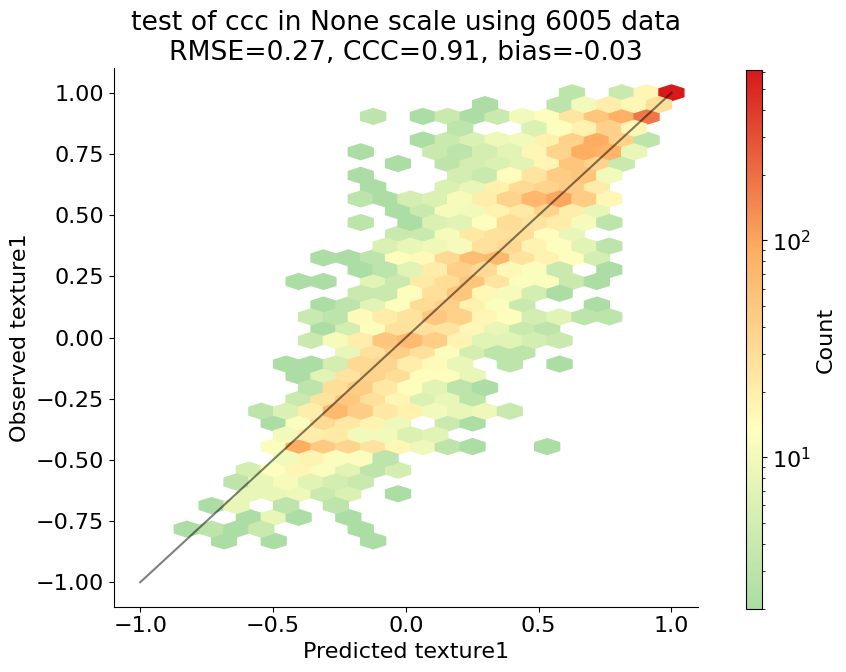

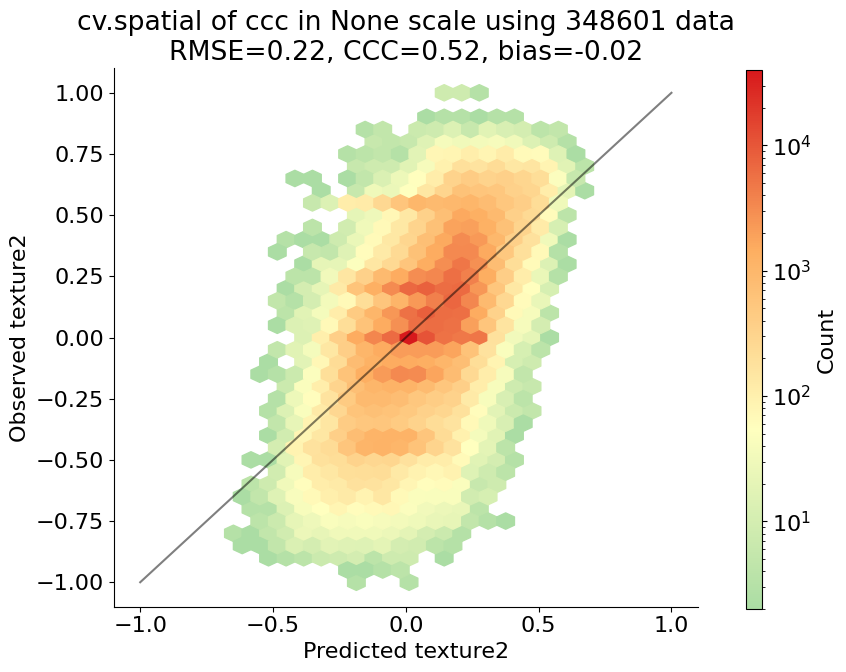

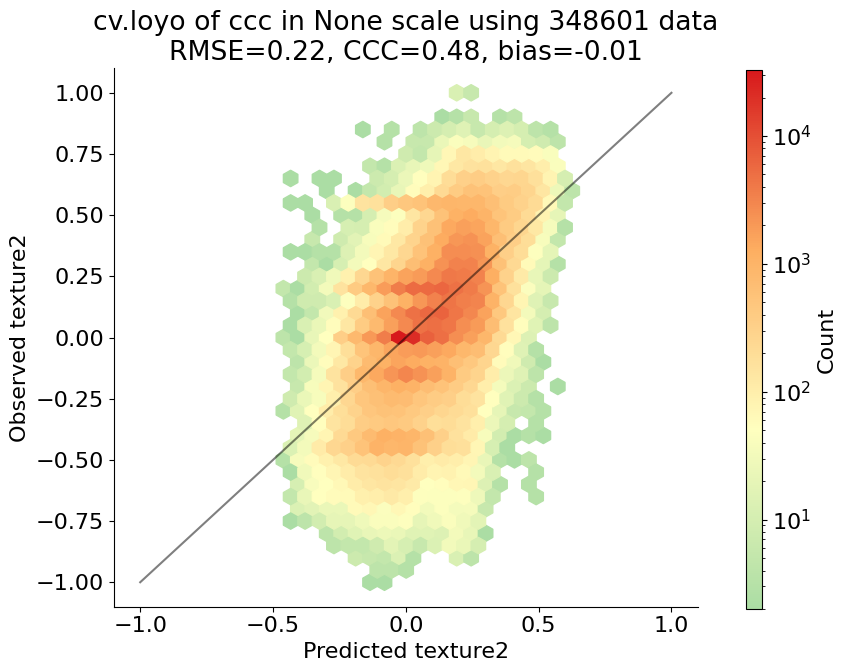

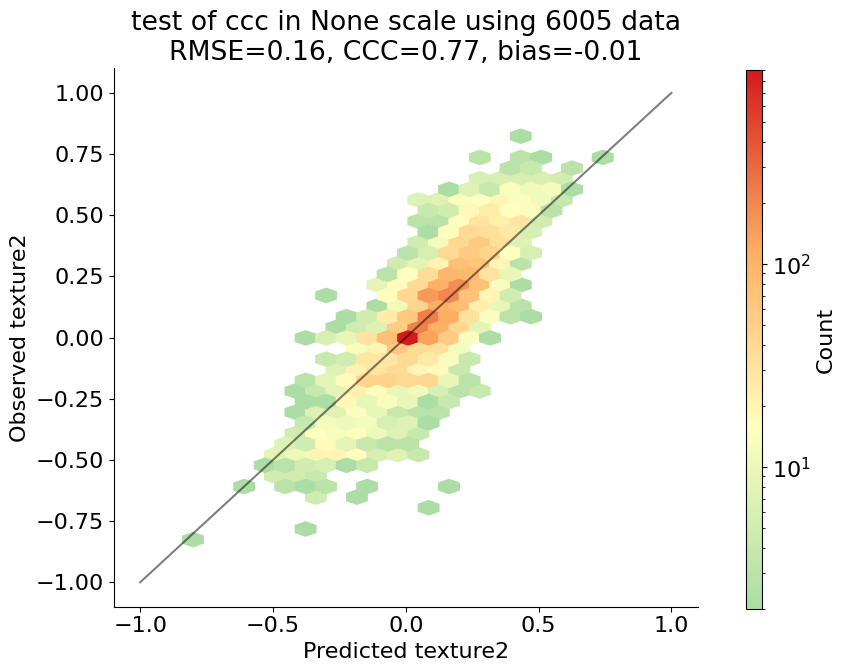

In [3]:
# general accuracy

results_cv = []

for prop in prop_list:
    print(f'\n{prop}--------------------------------------------------------------')
    space = transforms_dict[prop]
    output_folder = f'{folder_path}/textures'
    os.makedirs(output_folder, exist_ok=True)
    
    tgt = prop
    
    # read in data--------------------------------------------------------------
    train = pd.read_csv(f'{output_folder}/prediction_cv_{prop}_v{version}.csv')
    test = pd.read_csv(f'{output_folder}/prediction_test_{prop}_v{version}.csv')
    
    # accuracy plot
    model_list = find_files(output_folder,f'*model*rf*{prop}*{version}*joblib')
    model_list = [str(i) for i in model_list]
    
    for iii in range(len(model_list)):
        mdl = model_list[iii].split('_')[-2].split('.')[0]
        for test_type in ['cv.spatial', 'cv.loyo']:
            rmse, mae, medae, mape, ccc, r2, bias = accuracy_plot(train[tgt], train[f'{tgt}_{test_type}_{mdl}'], prop, space, mdl, test_type, folder_path)
            results_cv.append({
                'prop':prop,
                'model': mdl,
                'evaluation_type': test_type,
                'RMSE': rmse,
                'MAE': mae,
                'MedAE': medae,
                'MAPE': mape,
                'R2': r2,
                'CCC': ccc,
                'bias': bias
            })
            
        rmse, mae, medae, mape, ccc, r2, bias = accuracy_plot(test[tgt], test[f'{tgt}_test_{mdl}'], prop, space, mdl, 'test', folder_path)
        results_cv.append({
            'prop':prop,
            'model': mdl,
            'evaluation_type': 'test',
            'RMSE': rmse,
            'MAE': mae,
            'MedAE': medae,
            'MAPE': mape,
            'R2': r2,
            'CCC': ccc,
            'bias': bias
        })
        

### plot accuracy on original spaces

In [4]:
# covs
output_folder = f'{folder_path}/textures'
covs1 = read_features(f'{output_folder}/feature_selected_texture1_v{version}.txt') # read in
covs2 = read_features(f'{output_folder}/feature_selected_texture2_v{version}.txt') # read in
covs_list = [covs1, covs2]
all_covs = list(set(covs1 + covs2))
# data
train = pd.read_parquet(f'{output_folder}/data_train_textures_v{version}.pq')
test = pd.read_parquet(f'{output_folder}/data_test_textures_v{version}.pq')
test[all_covs] = test[all_covs].fillna(test[all_covs].median())
train[all_covs] = train[all_covs].fillna(train[all_covs].median())
    
mdl1 = joblib.load(f'{output_folder}/model_rf.texture1_ccc_v{version}.joblib')
mdl2 = joblib.load(f'{output_folder}/model_rf.texture2_ccc_v{version}.joblib')
model_list = [mdl1, mdl2]


In [5]:
from sklearn.model_selection import LeaveOneGroupOut,GroupKFold,cross_val_predict
# models
keep_col_cv = ['olc_id', 'site_key', 'source_db','year', 'hzn_dep', 'hzn_dep_bin', 'lat', 'lon', 'clm_class', 'clm_code', 'clay','silt','sand']
keep_col_test = ['olc_id', 'site_key', 'source_db','year', 'hzn_dep', 'hzn_dep_bin', 'lat', 'lon', 'clm_class', 'clm_code', 'clay','silt','sand']
    
for i in [0,1]:
    prop = prop_list[i]
    tgt = prop
    covs = covs_list[i]
    fi_df = pd.DataFrame(covs, columns=['feature'])
    
    model = model_list[i]
    model.n_jobs = 90
    model_name = 'rf'

    # cross validation------------------------------------------------------------
    # spatial cv
    cv = GroupKFold(n_splits=5) 
    ttprint(f'start spatial CV for {model_name}')
    y_scv = cross_val_predict(model, train[covs], train[tgt], cv=cv, groups=train['tile_id'])
    ttprint(f'finish spatial CV for {model_name}')
    train[f'{tgt}_cv.spatial_{model_name}'] = y_scv

    # temporal cv
    tgroups = train['year']
    logo = LeaveOneGroupOut()
    ttprint(f'start temporal CV for {model_name}')
    y_tcv = cross_val_predict(model, train[covs], train[tgt], cv=logo.split(train[covs], train[tgt], tgroups))
    ttprint(f'finish temporal CV for {model_name}')
    train[f'{tgt}_cv.loyo_{model_name}'] = y_tcv

    # test---------------------------------------------------------------------------
    ttprint(f'start test prediction for {model_name}')
    model.fit(train[covs], train[tgt])
    y_val = model.predict(test[covs])
    ttprint(f'finish test prediction for {model_name}')
    test[f'{tgt}_test_{model_name}'] = y_val

    # variable importance
    # pfi = permutation_importance(model, test[covs], test[tgt], n_jobs=80, n_repeats=10, random_state=42)
    # fi_df[f'{model_name} permutation importance'] = pfi.importances_mean
    importance_df = pd.DataFrame({'feature': covs, 'importance': model.feature_importances_})
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    importance_df.to_csv(f'{output_folder}/feature_importance_{model_name}_v{version}.csv', index=False)

    keep_col_cv = keep_col_cv + [ prop, tgt, f'{tgt}_cv.loyo_{model_name}', f'{tgt}_cv.spatial_{model_name}']
    keep_col_test = keep_col_test + [prop, tgt, f'{tgt}_test_{model_name}']

    # save
    # date_str = datetime.today().strftime('%Y%m%d')
    fi_df.to_csv(f'{output_folder}/feature_importance_{prop}_v{version}.csv',index=False)
    
train[keep_col_cv].to_csv(f'{output_folder}/prediction_cv_textures_v{version}.csv',index=False)
test[keep_col_test].to_csv(f'{output_folder}/prediction_test_textures_v{version}.csv',index=False)

[12:15:14] start spatial CV for rf
[12:16:09] finish temporal CV for rf
[12:16:09] 
start temporal CV for rf
[12:21:12] finish temporal CV for rf
[12:21:12] start test prediction for rf
[12:21:26] finish test prediction for rf
[12:21:26] start spatial CV for rf
[12:22:11] finish temporal CV for rf
[12:22:11] 
start temporal CV for rf
[12:26:24] finish temporal CV for rf
[12:26:24] start test prediction for rf
[12:26:36] finish test prediction for rf


In [6]:
# read in data--------------------------------------------------------------
texture_train = pd.read_csv(f'{output_folder}/prediction_cv_textures_v{version}.csv')
texture_test = pd.read_csv(f'{output_folder}/prediction_test_textures_v{version}.csv')

texture_test[f'sand_test_rf'], texture_test[f'silt_test_rf'], texture_test[f'clay_test_rf'] = textures_bw_transform(texture_test[f'texture1_test_rf'],texture_test[f'texture2_test_rf'])
for test_type in ['cv.spatial', 'cv.loyo']:
    texture_train[f'sand_{test_type}_rf'], texture_train[f'silt_{test_type}_rf'], texture_train[f'clay_{test_type}_rf'] = textures_bw_transform(texture_train[f'texture1_{test_type}_rf'],texture_train[f'texture2_{test_type}_rf'])


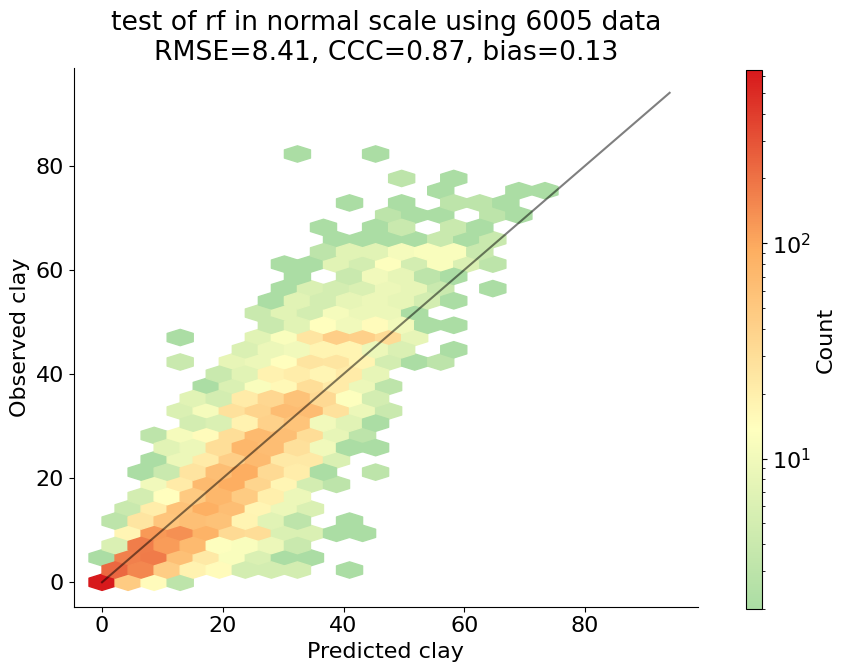

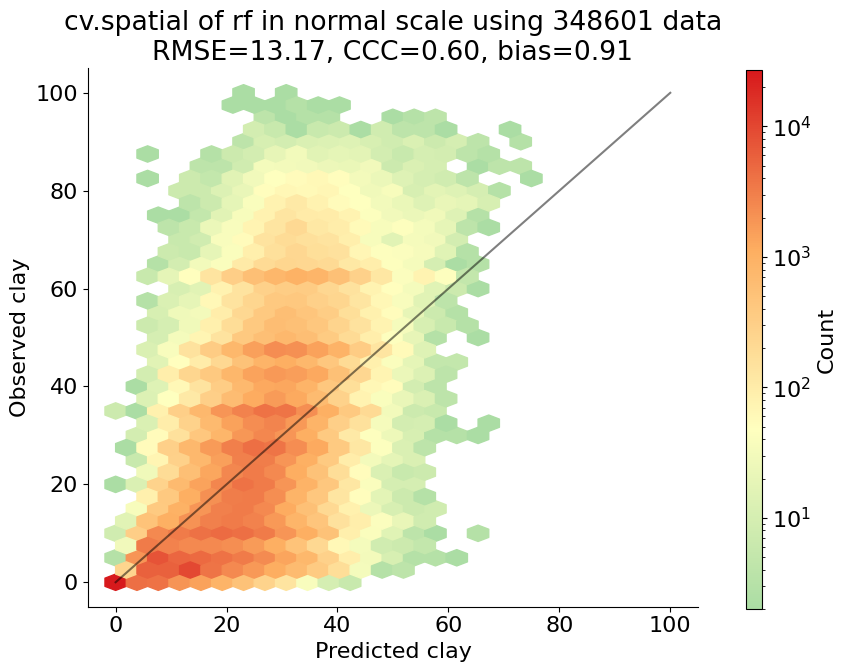

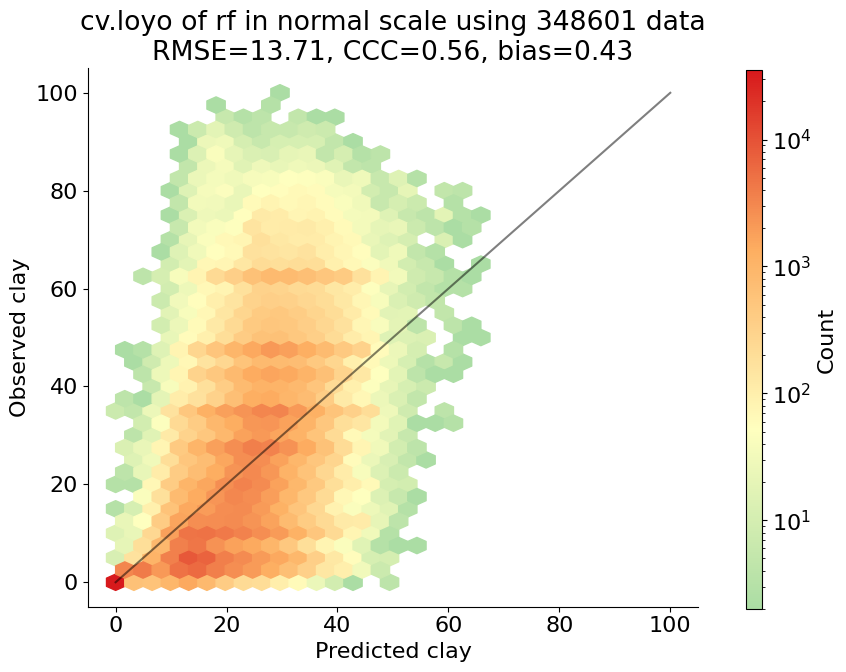

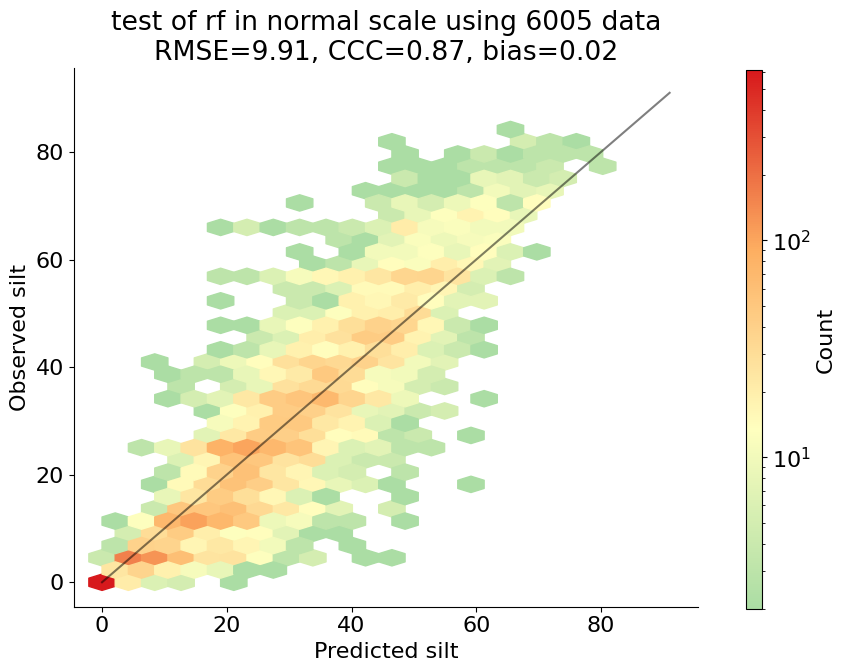

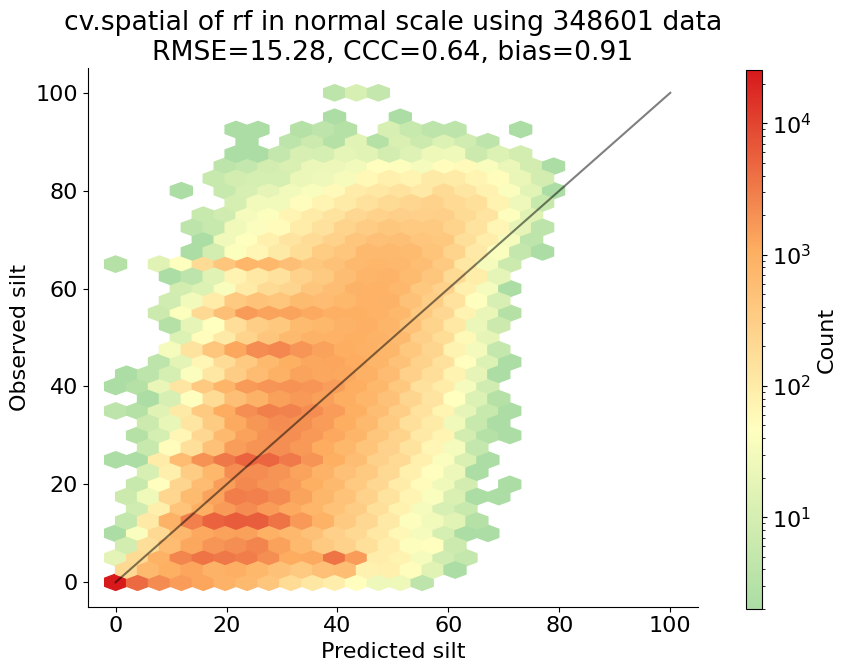

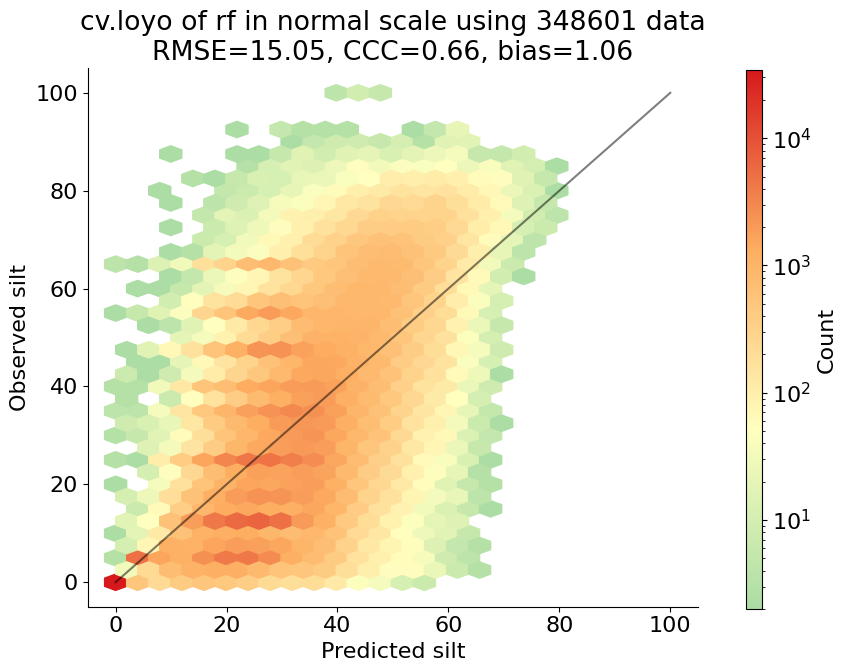

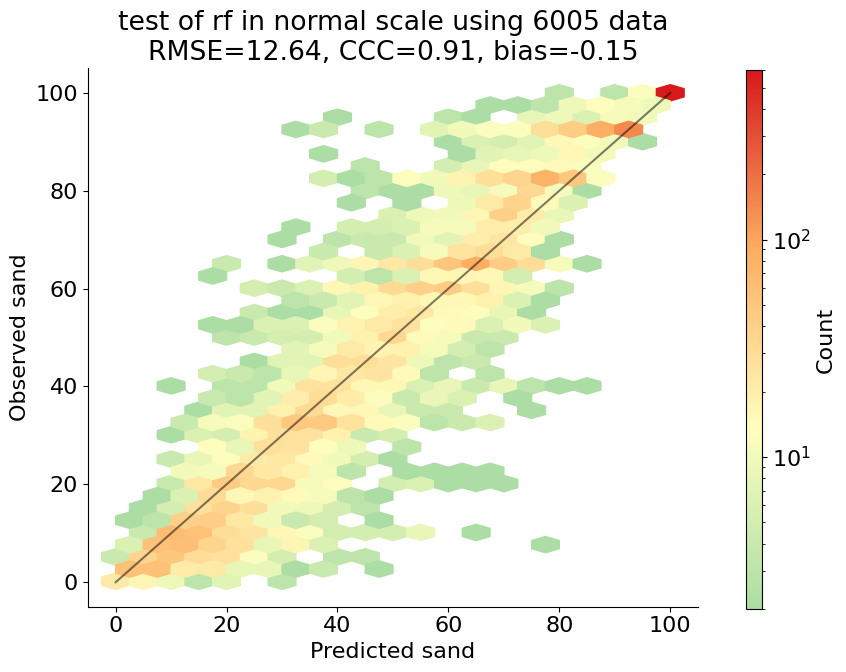

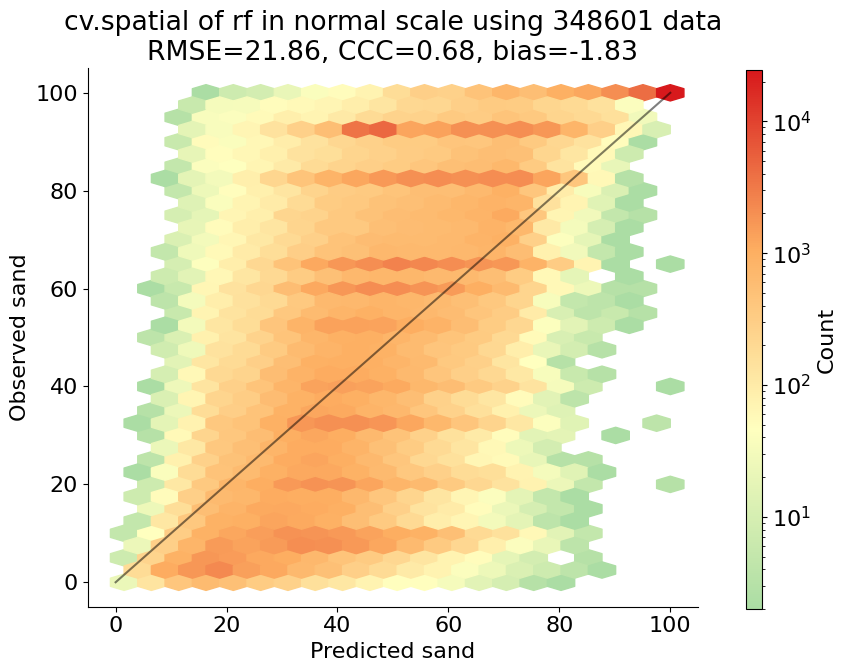

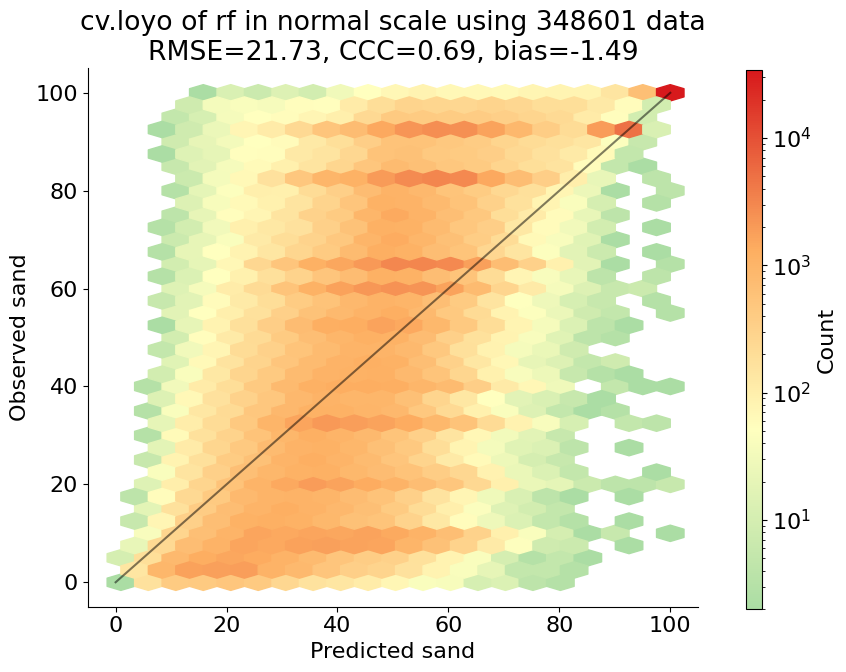

In [7]:
results_cv = []
for tx in ['clay','silt','sand']:
    rmse, mae, medae, mape, ccc, r2, bias = accuracy_plot(texture_test[tx], texture_test[f'{tx}_test_rf'], tx, 'normal', 'rf', 'test', output_folder)
    results_cv.append({
        'prop':tx,
        'model': 'rf',
        'evaluation_type': 'test',
        'RMSE': rmse,
        'MAE': mae,
        'MedAE': medae,
        'MAPE': mape,
        'R2': r2,
        'CCC': ccc,
        'bias': bias
    })
    
    for test_type in ['cv.spatial', 'cv.loyo']:
        rmse, mae, medae, mape, ccc, r2, bias = accuracy_plot(texture_train[tx], texture_train[f'{tx}_{test_type}_rf'], tx, 'normal', 'rf', test_type, output_folder)
        results_cv.append({
            'prop':tx,
            'model': 'rf',
            'evaluation_type': test_type,
            'RMSE': rmse,
            'MAE': mae,
            'MedAE': medae,
            'MAPE': mape,
            'R2': r2,
            'CCC': ccc,
            'bias': bias
        })
        
results_cv = pd.DataFrame(results_cv)
results_cv.to_csv(f'{output_folder}/metrics_texture.prop.csv',index=False)